# Overview
A bug in the method `porepy.utils.sort_points.sort_point_plane` is triggered by `pp.plot_grid(g)`. The following code reproduces the bug.

In [1]:
import porepy as pp
import numpy as np

/home/haakon/porepy/src/porepy/viz/exporter.py:928: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 1d, A), array(float64, 1d, C))
  angle = np.arccos(np.dot(normals[:, fi], reference))


In [2]:
n_cells = np.array([2, 2, 2])
physdims = np.array([10, 10, 10])

gb = pp.meshing.cart_grid(
            fracs=[],
            nx=n_cells,
            physdims=physdims,
        )
g = gb.grids_of_dimension(3)[0]

ValueError: operands could not be broadcast together with shapes (3,4) (3,) 

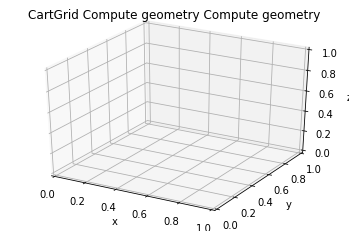

In [3]:
pp.plot_grid(g)

# Explanation:
The function `sort_point_plane` expects the argument `centre` to be a `3x1` numpy array. However, the method `porepy.viz.plot_grid.plot_grid_3d` passes a `1d`-array of length `3`.

# Proposed fix:
The function `sort_point_plane` needs to following modification:
* `_c = np.atleast_2d(centre)` 
* `centre = _c if _c.shape[0]>_c.shape[1] else _c.T`

# Test the proposed fix:

In [4]:
%debug

> /home/haakon/porepy/src/porepy/utils/sort_points.py(114)sort_point_plane()
    112     R = pp.map_geometry.project_plane_matrix(pts, normal)
    113     # project points and center,  project to plane
--> 114     delta = np.dot(R, pts - centre)
    115 
    116     # Find active dimension in the projected system

ipdb> _c = np.atleast_2d(centre)
ipdb> _c
array([[0. , 2.5, 2.5]])
ipdb> centre = _c if _c.shape[0]>_c.shape[1] else _c.T
ipdb> centre
array([[0. ],
       [2.5],
       [2.5]])
ipdb> np.dot(R, pts - centre)
array([[ 2.50000000e+00,  2.50000000e+00, -2.50000000e+00,
        -2.50000000e+00],
       [-2.50000000e+00,  2.50000000e+00, -2.50000000e+00,
         2.50000000e+00],
       [-2.77555756e-16, -2.77555756e-16,  2.77555756e-16,
         2.77555756e-16]])
ipdb> pts - centre
array([[ 0. ,  0. ,  0. ,  0. ],
       [-2.5,  2.5, -2.5,  2.5],
       [-2.5, -2.5,  2.5,  2.5]])
ipdb> q


# Additional verification:
Make sure that a `3x1` array remains unchanged

In [13]:
centre = np.array([[1], [2], [3]])
centre

array([[1],
       [2],
       [3]])

In [14]:
_c = np.atleast_2d(centre)
_c if _c.shape[0]>_c.shape[1] else _c.T

array([[1],
       [2],
       [3]])